Задача поиска объектов на изображении с использованием **Faster-RCNN**

[Датасет](https://www.kaggle.com/datasets/tarunbisht11/yolo-animal-detection-small/code?resource=download)

In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Faster-RCNN представляет объединение нескольких алгоритмов, поскольку решаемая задача не является в чистом виде задачей классификации или регрессии. Поэтому данный класс не имеют метода fit для обучения, поэтому для работы с ним требуется дополнительно подгружать функции из репозитория pytorch/vision. В файле engine.py прописана функция train_one_epoch(), используемая для обучения.

In [ ]:
%%shell

# Download Torch/Vision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 277558, done.
remote: Counting objects: 100% (16873/16873), done.
remote: Compressing objects: 100% (810/810), done.
remote: Total 277558 (delta 16102), reused 16767 (delta 16030), pack-reused 260685
Receiving objects: 100% (277558/277558), 555.29 MiB | 39.50 MiB/s, done.
Resolving deltas: 100% (253774/253774), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from engine import train_one_epoch, evaluate

Инструменты для аугментации (не используются при обучении, но, возможно, вы сможете найти им применение).


Функция get_new_picture() используется для получения нового изображения путём аугментации. Аугментация проводится путём поворота изображения на угол, который можно менять в функции get_good_angle() (сейчас он от 2 до 9 градусов), и цветокоррекции, степень которой также можно менять в функции get_good_offset().

In [ ]:
import random
import numpy
import imgaug as ia
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage


def get_good_angle():
    good_angle = random.uniform(-9, 9)
    while abs(good_angle) < 2:
        good_angle = random.uniform(-9, 9)
    return good_angle


def get_good_offset():
    offset = random.uniform(-0.12, 0.12)
    while abs(offset) < 0.03:
        offset = random.uniform(-0.12, 0.12)
    return offset


def get_new_picture(old_img, old_coords = []):
  coords=[]
  keypoints_only_xy = []
  ia.seed(1)
  for i in range(len(old_coords)):
    if i%2==0:
      keypoints_only_xy.append(Keypoint(x=int(float(old_coords[i])), y=int(float(old_coords[i+1]))))

  data = {}
  line_to_write = ""


  height, width, channels = old_img.shape

  image = ia.quokka(size=(height, width))
  kps = KeypointsOnImage(keypoints_only_xy, shape=image.shape)
  seq = iaa.Sequential([
      iaa.Multiply((1.2, 1.5)),  # change brightness, doesn't affect keypoints
      iaa.Affine(
          # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
          # scale images to 80-120% of their size, individually per axis
          translate_percent={"x": get_good_offset(), "y": get_good_offset()},
          # translate by -20 to +20 percent (per axis)
          rotate=get_good_angle(),
          scale=(random.uniform(0.7, 0.93), random.uniform(0.7, 0.93))

      )  # rotate by exactly 10deg and scale to 50-70%, affects keypoints
  ])

  # Augment keypoints and images.
  image_aug, kps_aug = seq(image=old_img, keypoints=kps)

  # print coordinates before/after augmentation (see below)
  # use after.x_int and after.y_int to get rounded integer coordinates
  for i in range(len(kps.keypoints)):
      before = kps.keypoints[i]
      after = kps_aug.keypoints[i]


      coords.append(after.x)
      coords.append(after.y)

  image_after = kps_aug.draw_on_image(image_aug, size=0)
  for i in range(len(coords)):
      coords[i]=int(coords[i])

  return image_after, coords



При аугментации учитывается изменение координат граничной области объекта на изображении. Координаты передаются в формате [x0, y0, x1, y1].

[-32, -84, 38, 2]


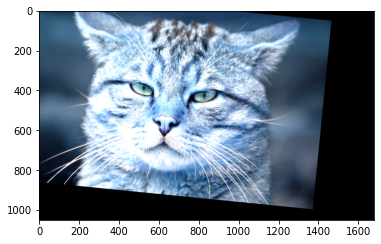

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt


# load img from url
pil_image = Image.open(requests.get("https://www.vladtime.ru/uploads/posts/2018-03/1522438548_evropeyskaya-koshka-dikiy-kot.jpg" , stream=True).raw)

open_cv_image = numpy.array(pil_image)

open_cv_image = open_cv_image[:, :, ::-1].copy()


old_coord_before = [ 12, 12, 100, 100]

image_after, new_coords = get_new_picture(open_cv_image, old_coord_before)
print(new_coords)
plt.imshow(image_after)
plt.show()

Загружаем данные с гугл-диска.


In [ ]:
from google.colab import drive


drive.mount('/content/drive')
id="/content/drive/MyDrive/ML/Object_detection"

Mounted at /content/drive


In [ ]:
train_csv_path = id+"/train.csv"
test_csv_path = id+"/test.csv"
train_images = id+"/yolo-animal-detection-small/train"
test_images = id+"/yolo-animal-detection-small/test"

Всего в датасете представлены изображения трёх классов животных (cat, dog, monkey), на каждом изображении могут быть несколько животных различных классов. Для каждого животного имеются границы области на изображении, в котором оно находится. Так как эта область считается прямоугольной, то для того, чтобы её однозначно задать требуются всего две точки (лежащие на одной диагонали).

In [ ]:
train_csv = pd.read_csv(train_csv_path)
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,cat,132,1,347,264
1,cats_002.jpg,474,474,cat,176,44,467,433
2,cats_003.jpg,474,314,cat,53,1,397,314
3,cats_004.jpg,474,355,cat,1,1,393,335
4,cats_005.jpg,474,316,cat,80,1,407,316


In [ ]:
train_csv.shape

(1309, 8)

In [ ]:
test_csv = pd.read_csv(test_csv_path)
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_000.jpg,474,632,cat,103,72,436,603
1,cats_007.jpg,474,266,cat,301,37,460,265
2,cats_007.jpg,474,266,cat,90,1,392,266
3,cats_050.jpg,474,237,cat,157,40,314,205
4,cats_072.jpg,474,266,cat,187,1,474,266


In [ ]:
test_csv.shape

(113, 8)

In [ ]:
categories = train_csv["class"].unique()
print(categories)

['cat' 'monkey' 'dog']


Заменяем название класса объекта на его номер.

In [ ]:
class LabelMap:
    def __init__(self, categories):
        self.map_dict = {}
        self.reverse_map_dict={}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat
    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df
    def inverse(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

In [ ]:
label_map = LabelMap(categories)

In [ ]:
train_csv = label_map.fit(train_csv, "class")
train_csv

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,1,132,1,347,264
1,cats_002.jpg,474,474,1,176,44,467,433
2,cats_003.jpg,474,314,1,53,1,397,314
3,cats_004.jpg,474,355,1,1,1,393,335
4,cats_005.jpg,474,316,1,80,1,407,316
...,...,...,...,...,...,...,...,...
1304,monkey_groups_097.jpg,474,316,2,233,146,285,273
1305,monkey_groups_097.jpg,474,316,2,330,92,461,270
1306,monkey_groups_097.jpg,474,316,2,257,115,361,272
1307,monkey_groups_099.jpg,474,266,2,18,9,302,266


In [ ]:
test_csv = label_map.fit(test_csv, "class")
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_000.jpg,474,632,1,103,72,436,603
1,cats_007.jpg,474,266,1,301,37,460,265
2,cats_007.jpg,474,266,1,90,1,392,266
3,cats_050.jpg,474,237,1,157,40,314,205
4,cats_072.jpg,474,266,1,187,1,474,266


Создаём класс AnimalDataset, необходимый для взаимодействия с данными при обучении.



**Формат target для задачи object detection в pytorch**

*boxes* (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format.

*labels* (Int64Tensor[N]): the label for each bounding box. 0 always represents the background class.

*image_id* (Int64Tensor[1]): an image identifier.

*area* (Tensor[N]): the area of the bounding box.

*iscrowd* (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.

In [ ]:
class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_path, categories, transforms=None,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.image_path = image_path
        self.categories = categories
        self.images = self.df["filename"].unique()
        self.transforms = transforms
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path, self.images[idx])
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        image_data = self.df[self.df['filename'] == self.images[idx]]
        labels = torch.as_tensor(image_data["class"].values, dtype=torch.int64)
        xmins = image_data["xmin"].values
        ymins = image_data["ymin"].values
        xmaxs = image_data["xmax"].values
        ymaxs = image_data["ymax"].values
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"],dtype=torch.float32)
        return torch.as_tensor(img, dtype=torch.float32), target
    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data["width"].values[0], image_data["height"].values[0]
def collate_fn(batch):
    return tuple(zip(*batch))

Классы для преобразования изображения к torch.Tensor.

In [ ]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transform_test = A.Compose([
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_dataset = AnimalDataset(train_csv, train_images, categories, transform_train)
test_dataset = AnimalDataset(test_csv, test_images, categories, transform_test)

In [ ]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=4, shuffle=True,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False,
    collate_fn=collate_fn)

Функция для визуализации данных.

In [ ]:
def plot_images(images, targets):
    for image, target in zip(images, targets):
        sample = image.permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        boxes = target["boxes"].cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        ax.set_axis_off()
        ax.imshow(sample)

In [ ]:
images, targets = next(iter(data_loader_train))

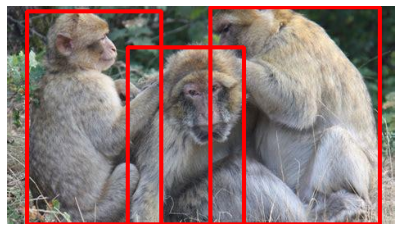

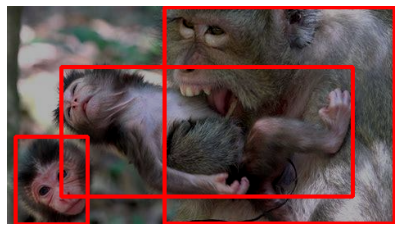

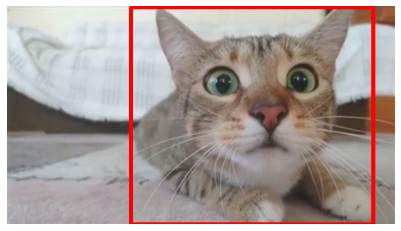

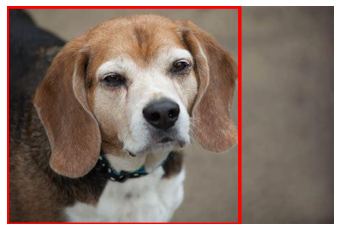

In [ ]:
plot_images(images, targets)

Идея R-CNN (Regions With CNNs) заключается в разбиении изображения на области с последующим проведением для каждой области классификации. Таким образом, можно определить, какой объект находится в каждой области, а потом работать уже только с теми областями, где находятся интересующие нас классы объектов.

Более подробно об этом можно прочитать по [ссылке](https://habr.com/ru/post/421299/).

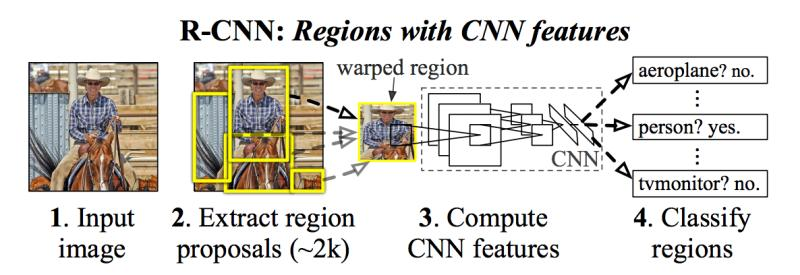

Алгоритм Faster-RCNN с использованием опорной модели ResNet50
:

In [ ]:
detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(categories)+1
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Алгоритм Faster-RCNN с использованием опорной модели MobileNetV3_small (пример того, как можно использовать Faster-RCNN с любой опорной моделью из pytorch)

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator
backbone = torchvision.models.mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT).features
backbone.out_channels = 576

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                            aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

detection_model =torchvision.models.detection.faster_rcnn.FasterRCNN(backbone, len(categories)+1, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
detection_model.eval()
detection_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

Указываем, что обучение модели будет происходить на GPU для экономии времени

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
detection_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def training(model, train_loader, val_loader, epochs=10):
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    for epoch in range(epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, val_loader, device=device)

In [ ]:
training(detection_model, data_loader_train, data_loader_test, epochs=5)

Epoch: [0]  [  0/118]  eta: 0:20:32  lr: 0.000048  loss: 1.5262 (1.5262)  loss_classifier: 1.3705 (1.3705)  loss_box_reg: 0.1447 (0.1447)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 10.4443  data: 1.5699  max mem: 4440
Epoch: [0]  [ 10/118]  eta: 0:05:46  lr: 0.000475  loss: 1.5054 (1.2585)  loss_classifier: 0.9665 (0.9102)  loss_box_reg: 0.3227 (0.3273)  loss_objectness: 0.0033 (0.0044)  loss_rpn_box_reg: 0.0193 (0.0167)  time: 3.2086  data: 1.3086  max mem: 7548
Epoch: [0]  [ 20/118]  eta: 0:04:47  lr: 0.000902  loss: 0.8823 (1.0180)  loss_classifier: 0.4670 (0.6652)  loss_box_reg: 0.3290 (0.3299)  loss_objectness: 0.0047 (0.0055)  loss_rpn_box_reg: 0.0156 (0.0174)  time: 2.5616  data: 1.3168  max mem: 7552
Epoch: [0]  [ 30/118]  eta: 0:04:12  lr: 0.001328  loss: 0.7094 (0.9438)  loss_classifier: 0.3183 (0.5577)  loss_box_reg: 0.3620 (0.3534)  loss_objectness: 0.0074 (0.0124)  loss_rpn_box_reg: 0.0172 (0.0204)  time: 2.6911  data: 1.4124  max mem: 7552

Визуализируем результат работы модели.

In [ ]:
images, targets = next(iter(data_loader_test))
detection_model.to('cpu')

targets_pred=detection_model(images)

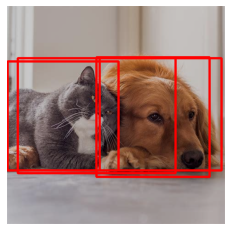

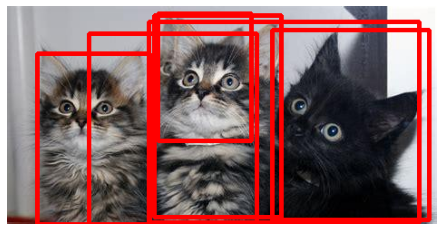

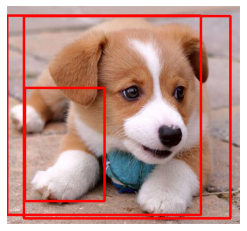

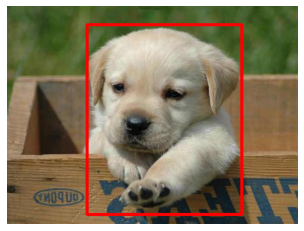

In [ ]:
for i in range(len(images)):
  sample = images[i].permute(1,2,0).cpu().numpy().copy()
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))
  boxes = targets_pred[i]["boxes"].detach().numpy().astype(np.int32)
  for box in boxes:
    cv2.rectangle(sample,
    (box[0], box[1]),
    (box[2], box[3]),
    (220, 0, 0), 3)
  ax.set_axis_off()
  ax.imshow(sample)

А так было в самом датасете.

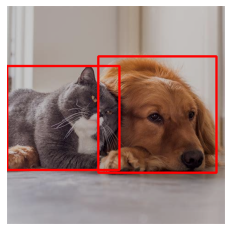

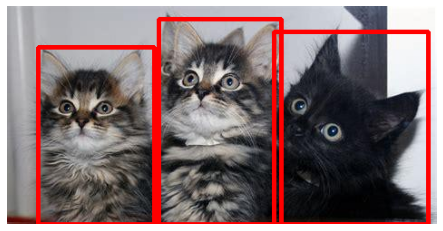

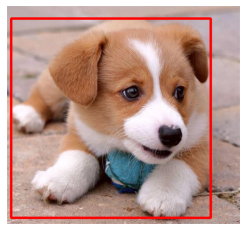

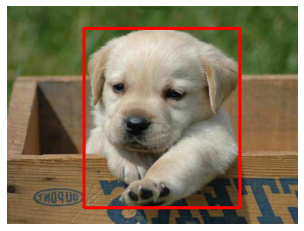

In [ ]:
for i in range(len(images)):
  sample = images[i].permute(1,2,0).cpu().numpy().copy()
  fig, ax = plt.subplots(1, 1, figsize=(8, 4))
  boxes = targets[i]["boxes"].detach().numpy().astype(np.int32)
  for box in boxes:
    cv2.rectangle(sample,
    (box[0], box[1]),
    (box[2], box[3]),
    (220, 0, 0), 3)
  ax.set_axis_off()
  ax.imshow(sample)

Считаем точность:

tp - количество правильно определённых объектов (считаем допустимой погрешность координат областей в 7 процентов)

fp - количество найденных моделей объектов, которых на изображении нет

fn - количество не найденных моделью объектов

In [ ]:
tp=0
fn=0
fp=0
detection_model.to(device)

for i in range(test_dataset.__len__()):
  img, target = test_dataset.__getitem__(i)
  img=img.to(device)
  pred=detection_model([img])
  res=[0 for j in range(len(target["labels"]))]
  for j in range(len(pred[0]["labels"])):
    w=abs(pred[0]["boxes"][j][0] - pred[0]["boxes"][j][2])
    h=abs(pred[0]["boxes"][j][1] - pred[0]["boxes"][j][3])
    dw=w/100*7
    dh=h/100*7
    flag=False
    for k in range(len(target["labels"])):
      if res[k]==0:
        if(abs(pred[0]["boxes"][j][0]- target["boxes"][k][0])<dw and abs(pred[0]["boxes"][j][2]- target["boxes"][k][2])<dw and abs(pred[0]["boxes"][j][1]- target["boxes"][k][1])<dh and abs(pred[0]["boxes"][j][3]- target["boxes"][k][3])<dh and pred[0]["labels"][j]==target["labels"][k]):
          tp+=1
          flag=True
          res[k]=1
          break
    if not(flag):
      fp+=1
    for k in range(len(res)):
      if res[k]==0:
        fn+=1
print(tp/(tp+fn+fp)*100)


10.247026532479413
